In [ ]:
>>> sort out reviewS vs review .._count
>>> check out lookback windowon and reviews-based aggs
>>> get rid of unnamed and drop dupes
>>> check min days b/t inspection dates for a given restaurant
>>> decide whether to keep or drop follow up inspections

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
#import statsmodels as sm
import statsmodels.api as sm
from sklearn.metrics import (confusion_matrix, accuracy_score)

# for sentiment analysis
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize


In [2]:
yelp_reviews_tx = pd.read_csv('yelp_reviews_tx.csv')
yelp_reviews_tx.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,0,GDgXjXSZCA1iNQWD7OHXfg,1RCRKuHgP3FskGUVnmFdxg,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,I think their rice dishes are way better than ...,2017-05-26 03:05:46
1,1,xxUbWSkZtPHrPFT_RhW68A,ZuB2N9UOIooj9nPtI3Re5g,mOnesB4IF9j6-ZmHoOHOig,2,0,0,0,I've given this place a couple of chances and ...,2014-01-17 00:55:26
2,2,48wQst-NfdRPpu32cUEsaA,AQUdnD35RBuCXNx0KxE5wA,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,Definitely one of my favorite places for vietn...,2015-06-21 00:30:24
3,3,0-k1eqpn_i2FnyBBwtFSYw,IYRlxx4G8fkkc6x_gk4sPg,mOnesB4IF9j6-ZmHoOHOig,5,0,0,0,My favorite Vietnamese restaurant in town. I l...,2017-09-08 23:20:38
4,4,JF4NXGCyOgkUIQzRlQRuuw,ZYs9y2Hk_C55Ynr40TGmUA,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,"Good food, good price, and good service. You ...",2010-07-07 16:27:26


In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ellerybledsoe/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

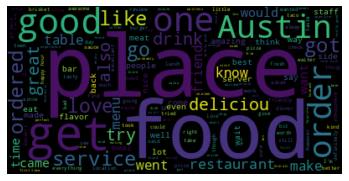

In [21]:
# Create stopword list:
#STOPWORDS = ['great','good']
#stopwords = set(STOPWORDS)
stopwords = set(stopwords.words('english'))
#stopwords.update(["br", "href"])

textt = " ".join(review for review in yelp_reviews_tx.text)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [24]:
yelp_reviews_tx[['stars']].head()

,stars
0,4
1,2
2,4
3,5
4,4


In [27]:
yelp_reviews_tx['sentiment'] = yelp_reviews_tx['stars'].apply(lambda stars : +1 if stars > 3 else (0.5 if stars == 3 else 0))


In [28]:
yelp_reviews_tx[['stars','sentiment']].head()

# https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6

,stars,sentiment
0,4,1.0
1,2,0.0
2,4,1.0
3,5,1.0
4,4,1.0


In [35]:
positive = yelp_reviews_tx[yelp_reviews_tx['sentiment'] == 1.0]
neutral = yelp_reviews_tx[yelp_reviews_tx['sentiment'] == 0.5]
negative = yelp_reviews_tx[yelp_reviews_tx['sentiment'] == 0.0]

In [37]:
positive['text'].head()

0    I think their rice dishes are way better than ...
2    Definitely one of my favorite places for vietn...
3    My favorite Vietnamese restaurant in town. I l...
4    Good food, good price, and good service.  You ...
5    This place is delicious! I work right down the...
Name: text, dtype: object

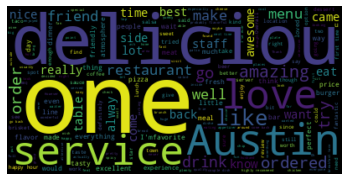

In [41]:
#stopwords = set(STOPWORDS)
stopwords.update(["br", "href","good","great","place","get","got","went","food","also"]) ## good and great removed because they were included in negative sentiment

pos = " ".join(review for review in positive.text)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)

plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()